<a href="https://colab.research.google.com/github/MiHarsh/Pytorch_Fanatics/blob/master/Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip -qq /content/0664343c9a8f11ea.zip

In [2]:
import os
import torch
import albumentations

import numpy as np
import pandas as pd

import torch.nn as nn
from sklearn import metrics
from sklearn import model_selection
from torch.nn import functional as F

!pip install timm --quiet
import timm

import warnings
warnings.filterwarnings("ignore")


     |████████████████████████████████| 215kB 8.6MB/s 


In [0]:
#Seed everything at ones for reproducibility
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

***Making Stratified K fold....***

In [0]:
Data_dir='/content/dataset/'
df=pd.read_csv(Data_dir+'train.csv')
df_dict={'manipuri':0, 'bharatanatyam':1, 'odissi':2, 'kathakali':3, 'kathak':4,
       'sattriya':5, 'kuchipudi':6, 'mohiniyattam':7}
df.target=df.target.map(df_dict)

df["kfold"] = -1    
df =df.sample(frac=1).reset_index(drop=True)
y = df.target.values
kf =model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv("train_folds.csv", index=False)

In [0]:
class EfficientNetb0(nn.Module):
    def __init__(self):
        super(EfficientNetb0, self).__init__()
        self.base_model =timm.create_model('efficientnet_b0',pretrained=True,num_classes=8)
        
    def forward(self, image, targets):
        batch_size, _, _, _ = image.shape
        out = self.base_model(image)
        loss = nn.CrossEntropyLoss()(out, targets)
        return out, loss

In [0]:
!pip install pytorch_fanatics --quiet
from pytorch_fanatics.dataloader import Cloader
from pytorch_fanatics.trainer import Trainer
from pytorch_fanatics.utils import EarlyStop
from pytorch_fanatics.utils import LRFinder
from pytorch_fanatics.logger import Logger

In [0]:
def train(fold):
    training_data_path = "/content/dataset/train"
    df = pd.read_csv("train_folds.csv")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 10
    train_bs = 128
    valid_bs = 64

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    model = EfficientNetb0()
    model.to(device)

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_aug = albumentations.Compose(
        [
            albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
            albumentations.Flip(p=0.5)
        ]
    )

    valid_aug = albumentations.Compose(
        [
            albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
        ]
    )

    train_images = df_train.Image.values.tolist()
    train_images = [os.path.join(training_data_path, i) for i in train_images]
    train_targets = df_train.target.values

    valid_images = df_valid.Image.values.tolist()
    valid_images = [os.path.join(training_data_path, i) for i in valid_images]
    valid_targets = df_valid.target.values

    train_dataset = Cloader(
        image_path=train_images,
        targets=train_targets,
        resize=(224,224),
        transforms=train_aug,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_bs, shuffle=True, num_workers=4
    )

    valid_dataset = Cloader(
        image_path=valid_images,
        targets=valid_targets,
        resize=(224,224),
        transforms=valid_aug,
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=3,
        threshold=0.001,
        mode="max"
    )
    
    
    es = EarlyStop(patience=5, mode="max")

    for epoch in range(epochs):
        Trainer.train(model,train_loader,optimizer,device)
        metric_score= Trainer.evaluate(
            model,valid_loader,device,scheduler) #default metric is accuracy
        
        es(metric_score, model, model_path="model_best.pth")
        Logger.save(model,optimizer,scheduler,'checkpoint.pth') #Use Logger to train from where it was left
        if es.early_stop:
            print("Early stopping")
            break
    Trainer.get_log().to_csv(f'fold{fold}log.csv') #This will directly save the log
    Trainer.reset()


   Train_Loss  Valid_Loss  Metric_Score  Current_LR
0    0.103336    0.257615      0.438356      0.0010
1    0.032447    0.213499      0.575342      0.0010
2    0.006251    0.359913      0.630137      0.0010
3    0.004607    0.355868      0.684932      0.0010
4    0.011814    0.261907      0.726027      0.0010
5    0.002905    0.186034      0.698630      0.0010
6    0.007312    0.150990      0.671233      0.0010
7    0.001760    0.168527      0.671233      0.0010
8    0.003411    0.240755      0.643836      0.0010
9    0.001787    0.205086      0.657534      0.0001


Traceback (most recent call last):
TypeError: 'NoneType' object is not callable


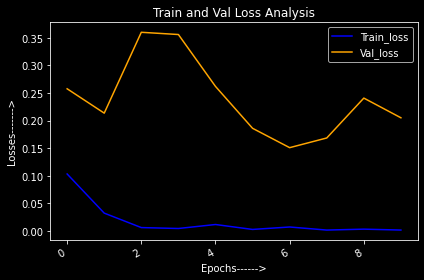

EarlyStop count: 5 out of 5
Early stopping


In [8]:
train(0)